In [36]:
import numpy as np
from gekko import GEKKO
import matplotlib.pyplot as plt
import pandas as pd

In [37]:
czantoria_full = pd.read_csv('data/csv/czantoria_sauce.csv')
czantoria_full.columns = ['time', 'distance', 'heartrate', 'cadence', 'velocity_smooth', 'altitude', 'grade_smooth']
czantoria_nonzero = czantoria_full[(czantoria_full['velocity_smooth'] > 0) | (czantoria_full['time'] == 0)]
czantoria_time = czantoria_nonzero.groupby('distance').agg({'time': 'max'}).reset_index()['time']
czantoria_final = pd.merge(czantoria_nonzero, czantoria_time, on=['time'])

In [38]:
distance_data = czantoria_final['distance'].to_numpy()
grade_data = czantoria_final['grade_smooth'].to_numpy()
elevation_data = czantoria_final['altitude'].to_numpy()

In [39]:
distance_data = czantoria_final['distance'].to_numpy()
grade_data = czantoria_final['grade_smooth'].to_numpy()
elevation_data = czantoria_final['altitude'].to_numpy()

n = grade_data.shape[0]
to_stay = np.zeros(n)
to_stay[0] = 1

grade_data = grade_data

for i in range(n - 1):
    if np.abs(grade_data[i+1] - grade_data[i]) < 1:
        grade_data[i+1] = grade_data[i]
        to_stay[i+1] = 0
    else:
        to_stay[i+ 1] = 1

grade_data = grade_data[to_stay == 1]
distance_data = distance_data[to_stay == 1]

In [40]:
grade_data = np.arctan(grade_data/100)

In [42]:
m = GEKKO()

nt = 101
tm = np.linspace(0,1,nt)
m.time = tm

distance = 1000

# constants
sm = 39.0 #maximal VO2
e0 = 2000 #starting level of energy
e_crit = 0.15 * e0 #critical level of energy, when sigma decreases
g = 9.81 #gravitational constant
mass = 75

# curve coefficients
# a = 60 * 50.65
# b = 192.86 / 50.65
k = 0.03734

# sigma data to create spline
E_data = np.linspace(0, e0, 1001)
sigma_data = sm * E_data/(e0 * e_crit) + 0.75 * sm * (1 - E_data/(e0 * e_crit))
sigma_data[E_data > e_crit] = sm

# slope data to create spline
# x_data = np.linspace(0, distance, 500)
# slope_data = np.array(250*[1/18 * np.pi] + 250 * [-1/18 * np.pi])

x_data = distance_data
slope_data = grade_data

# Variables
v = m.Var(value=0.0, lb=0.0, ub=7.0)
E = m.Var(value=e0, lb=0.0)
x = m.Var(value=0.0)
N = m.Var(value=0.00201818, lb=0.0)
# t = m.Var(value=0.0)

sigma = m.Var(value=sm, lb=0)
sigma_max = m.Var()
slope = m.Var(value=slope_data[0])

p = np.zeros(nt)
p[-1] = 1.0
final = m.Param(value=p)

# FV
tf = m.FV(value=250.0,lb=0.1,ub=300.0)
tf.STATUS = 1

# MV
u = m.MV(value=0,lb=0,ub=12)
u.STATUS = 1

# energy decrease at the end
m.cspline(E, sigma_max, E_data, sigma_data, True)

# slope
m.cspline(x, slope, x_data, slope_data, True)


m.Equation(v.dt()==(u - g * m.sin(slope) - v/0.892)*tf)
m.Equation(E.dt()==(sigma - u*v + N * 4 * 4184 * 1/mass)*tf)
m.Equation(x.dt()==(v*m.cos(slope))*tf)
m.Equation(N.dt()==(k*N*(0.0222-N))*tf)
# m.Equation(t.dt()==1)
m.Equation(sigma<=sigma_max)

m.Equation((distance-x)*final<=0)

m.Minimize(tf)

m.options.IMODE = 6
m.options.MAX_ITER=15000

m.solve()

print('Final Time: ' + str(tf.value[0]))

tm = tm * tf.value[0]

apm 90.156.80.122_gk_model3 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            2
   Constants    :            0
   Variables    :           12
   Intermediates:            0
   Connections  :            4
   Equations    :            7
   Residuals    :            7
 
 Number of state variables:           1801
 Number of total equations: -         1600
 Number of slack variables: -          200
 ---------------------------------------
 Degrees of freedom       :              1
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipop

  59  1.4327720e+04 2.57e+04 5.48e+17  10.3 5.16e+03  13.6 3.53e-02 1.10e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.4521274e+04 2.48e+04 7.17e+17   9.6 5.55e+03  13.1 3.72e-02 3.59e-02h  1
  61  1.4762083e+04 2.46e+04 7.77e+17   8.9 7.32e+03  12.6 8.33e-03 7.63e-03h  1
  62  1.4762029e+04 2.46e+04 7.76e+17   8.2 4.74e+03  13.1 4.43e-02 5.46e-04h  1
  63  1.4762229e+04 2.46e+04 1.61e+18   7.5 4.76e+03  13.5 8.27e-02 1.25e-05h  1
  64  1.5083168e+04 2.40e+04 1.62e+18   6.8 5.19e+03  13.0 4.36e-02 2.02e-02h  1
  65  1.5122137e+04 2.40e+04 2.42e+18   6.1 4.74e+03  13.4 6.92e-02 1.88e-03h  1
  66  1.5582672e+04 2.34e+04 1.67e+18   5.4 4.51e+03  13.9 2.60e-03 2.21e-02h  1
  67  1.5586375e+04 2.34e+04 3.92e+18   4.7 8.28e+03  14.3 1.86e-02 2.45e-04h  1
  68  1.5623070e+04 2.34e+04 4.57e+18   4.0 6.26e+03  13.8 2.00e-02 2.10e-03h  1
  69  1.5669787e+04 2.33e+04 6.67e+18   3.3 6.61e+03  14.2 1.81e-02 2.12e-03h  1
iter    objective    inf_pr 

 151  1.2241204e+04 1.12e+04 1.14e+14   1.9 7.62e+02  10.8 1.01e-03 5.83e-04h  1
 152  1.2260082e+04 1.12e+04 1.14e+14   1.9 7.38e+02  10.4 2.00e-03 3.55e-03h  1
 153  1.2270626e+04 1.11e+04 1.14e+14   1.9 7.56e+02  10.8 5.15e-03 1.98e-03h  1
 154  1.2311463e+04 1.10e+04 1.13e+14   1.9 1.07e+03  10.3 8.90e-03 7.31e-03h  1
 155  1.2330539e+04 1.10e+04 3.54e+14   1.9 7.43e+02  10.7 5.29e-02 3.22e-03h  1
 156  1.2460187e+04 1.08e+04 3.47e+14   1.9 1.34e+03  10.3 2.33e-02 2.25e-02h  1
 157  1.2467784e+04 1.07e+04 7.16e+14   1.9 7.25e+02  10.7 7.13e-02 1.15e-03h  1
 158  1.2613159e+04 1.05e+04 7.58e+14   1.9 7.35e+02  11.1 2.54e-02 2.13e-02h  1
 159  1.2905689e+04 9.97e+03 1.10e+15   1.9 9.29e+02  10.6 4.32e-02 4.70e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  1.2951836e+04 9.89e+03 1.35e+15   1.9 7.49e+02  11.1 6.69e-02 7.52e-03h  1
 161  1.2963874e+04 9.87e+03 3.07e+15   1.9 6.87e+02  11.5 7.43e-02 1.89e-03h  1
 162  1.3139428e+04 9.58e+03

 243  3.0660393e+04 4.31e+01 2.95e+03   1.5 2.65e+02  -1.5 1.00e+00 1.00e+00H  1
 244  3.0631679e+04 2.88e-01 1.44e+02   0.8 1.09e+01  -1.1 1.00e+00 1.00e+00h  1
 245  3.0535855e+04 1.25e-01 2.70e+00   0.1 3.40e+00  -1.6 1.00e+00 1.00e+00f  1
 246  3.0278271e+04 7.39e-01 7.96e-01  -0.6 7.51e+00  -2.1 1.00e+00 1.00e+00f  1
 247  2.9610145e+04 5.00e+00 6.08e+06  -1.3 1.97e+01  -2.6 6.70e-01 1.00e+00f  1
 248  2.7893832e+04 3.69e+01 2.74e-01  -1.3 5.22e+01  -3.0 1.00e+00 1.00e+00f  1
 249  2.5970998e+04 6.27e+01 6.49e-01  -1.3 1.06e+02  -3.5 6.77e-01 5.98e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  2.5157019e+04 4.43e+01 4.20e+00  -1.3 1.53e+02  -4.0 1.00e+00 4.27e-01h  1
 251  2.4340164e+04 4.34e+01 2.16e+00  -1.3 2.25e+02  -4.5 1.00e+00 2.79e-01h  1
 252  2.2776833e+04 1.05e+02 1.16e+00  -1.3 3.02e+02  -4.9 1.00e+00 3.79e-01h  1
 253  2.1389644e+04 2.45e+02 6.50e+00  -1.3 4.24e+02  -5.4 1.00e+00 3.89e-01h  1
 254  2.1522325e+04 2.24e+01

 346  1.8646078e+04 5.22e-01 2.02e+03  -4.6 2.64e+02  -5.5 1.00e+00 1.19e-01h  1
 347  1.8648400e+04 7.04e+00 2.31e+04  -3.4 7.00e+01  -5.1 1.00e+00 3.63e-01f  1
 348  1.8616675e+04 2.29e+01 4.64e+03  -3.5 1.23e+02  -5.6 1.00e+00 7.40e-01h  1
 349  1.8606876e+04 1.91e+01 7.12e+03  -4.4 3.98e+01  -4.3 5.69e-01 1.68e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350  1.8606189e+04 1.76e+01 2.12e+04  -3.3 1.52e+01  -3.8 9.05e-01 7.82e-02h  1
 351  1.8606052e+04 1.74e+01 7.19e+04  -3.0 2.47e+01  -4.3 8.92e-01 1.11e-02h  1
 352  1.8584055e+04 1.18e+01 5.58e+04  -4.6 1.12e+02  -4.8 2.49e-01 3.27e-01h  1
 353  1.8639158e+04 1.33e+01 1.56e+05  -2.6 4.70e+01  -4.4 1.55e-01 1.00e+00f  1
 354  1.8639900e+04 1.09e+01 1.35e+05  -3.0 3.83e+00  -1.2 8.33e-01 1.78e-01h  1
 355  1.8643276e+04 7.67e+00 3.42e+04  -3.0 6.54e+00  -0.8 5.53e-01 7.45e-01h  1
 356  1.8643423e+04 7.42e+00 3.39e+04  -3.0 7.20e+00   1.4 1.00e+00 3.15e-02h  1
 357  1.8643713e+04 7.08e+00

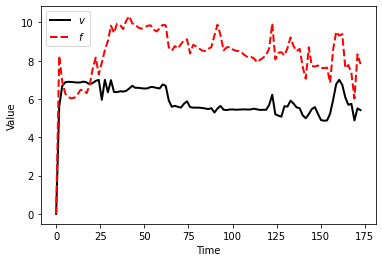

In [43]:
plt.figure(1)
plt.plot(tm,v.value,'k-',lw=2,label=r'$v$')
plt.plot(tm,u.value,'r--',lw=2,label=r'$f$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

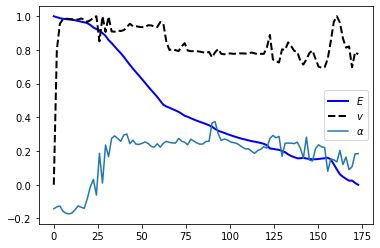

In [44]:
plt.figure(2)
plt.plot(tm,np.array(E.value)/max(E.value),'b-',lw=2,label=r'$E$')
plt.plot(tm,np.array(v.value)/max(v.value),'k--',lw=2,label=r'$v$')
plt.plot(tm,slope, label=r'$\alpha$')
plt.legend()
plt.show()

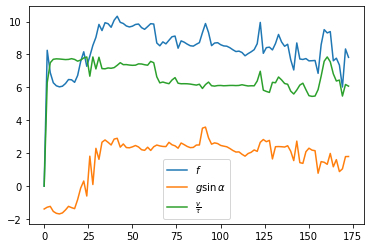

In [45]:
# dv/dt
plt.plot(tm, u.value, label='$f$')
plt.plot(tm, g*np.sin(slope.value), label=r'$g\sin \alpha$')
plt.plot(tm, np.array(v.value)/0.892, label=r'$\frac{v}{\tau}$')
plt.legend()
plt.show()

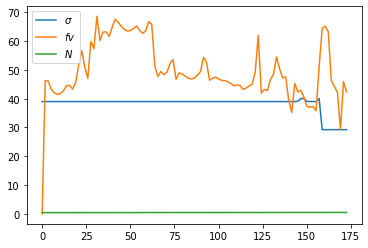

In [46]:
# dE/dt
plt.plot(tm, sigma.value, label=r'$\sigma$')
plt.plot(tm, np.multiply(np.array(u.value), np.array(v.value)), label=r'$fv$')
plt.plot(tm, np.array(N.value) * 4 * 4184 * 1/mass, label=r'$N$')
plt.legend()
plt.show()